<a href="https://colab.research.google.com/github/matteokarldonati/Counterfactual-Multi-Agent-Policy-Gradients/blob/master/COMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Counterfactual Multi-Agent Policy Gradients


In [1]:
!rm -rf /content/ma-gym  
!git clone https://github.com/koulanurag/ma-gym.git 
%cd /content/ma-gym 
!pip install -q -e . 
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install -U gym[atari] > /dev/null 2>&1

fatal: destination path 'ma-gym' already exists and is not an empty directory.
[Errno 2] No such file or directory: '/content/ma-gym'
/home/koen/Programming/Counterfactual-Multi-Agent-Policy-Gradients
ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /home/koen/Programming/Counterfactual-Multi-Agent-Policy-Gradients
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Requirement already up-to-date: setuptools in ./.venv/lib/python3.6/site-packages (50.3.2)


In [3]:
%matplotlib inline
import gym
import ma_gym
from ma_gym.wrappers import Monitor
import matplotlib.pyplot as plt
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## COMA

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions import Categorical

In [5]:
class Memory:
    def __init__(self, agent_num, action_dim):
        self.agent_num = agent_num
        self.action_dim = action_dim

        self.actions = []
        self.observations = []
        self.pi = [[] for _ in range(agent_num)]
        self.reward = []
        self.done = [[] for _ in range(agent_num)]

    def get(self):
        actions = torch.tensor(self.actions)
        observations = self.observations

        pi = []
        for i in range(self.agent_num):
          pi.append(torch.cat(self.pi[i]).view(len(self.pi[i]), self.action_dim))

        reward = torch.tensor(self.reward)
        done = self.done

        return actions, observations, pi, reward, done
    
    def clear(self):
        self.actions = []
        self.observations = []
        self.pi = [[] for _ in range(agent_num)]
        self.reward = []
        self.done = [[] for _ in range(agent_num)]

In [6]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), dim=-1)

In [7]:
class Critic(nn.Module):
    def __init__(self, agent_num, state_dim, action_dim):
        super(Critic, self).__init__()

        input_dim = 1 + state_dim * agent_num + agent_num

        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
class COMA:
    def __init__(self, agent_num, state_dim, action_dim, lr_c, lr_a, gamma, target_update_steps):
        self.agent_num = agent_num
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.gamma = gamma

        self.target_update_steps = target_update_steps

        self.memory = Memory(agent_num, action_dim)

        self.actors = [Actor(state_dim, action_dim) for _ in range(agent_num)]
        self.critic = Critic(agent_num, state_dim, action_dim)

        self.critic_target = Critic(agent_num, state_dim, action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actors_optimizer = [torch.optim.Adam(self.actors[i].parameters(), lr=lr_a) for i in range(agent_num)]
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_c)

        self.count = 0

    def get_actions(self, observations):
        observations = torch.tensor(observations)

        actions = []

        for i in range(self.agent_num):
            dist = self.actors[i](observations[i])
            action = Categorical(dist).sample()

            self.memory.pi[i].append(dist)
            actions.append(action.item())

        self.memory.observations.append(observations)
        self.memory.actions.append(actions)

        return actions

    def train(self):
        actor_optimizer = self.actors_optimizer
        critic_optimizer = self.critic_optimizer

        actions, observations, pi, reward, done = self.memory.get()

        for i in range(self.agent_num):
            # train actor

            input_critic = self.build_input_critic(i, observations, actions)
            Q_target = self.critic_target(input_critic).detach()

            action_taken = actions.type(torch.long)[:, i].reshape(-1, 1)

            baseline = torch.sum(pi[i] * Q_target, dim=1).detach()
            Q_taken_target = torch.gather(Q_target, dim=1, index=action_taken).squeeze()
            advantage = Q_taken_target - baseline

            log_pi = torch.log(torch.gather(pi[i], dim=1, index=action_taken).squeeze())

            actor_loss = - torch.mean(advantage * log_pi)

            actor_optimizer[i].zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.actors[i].parameters(), 5)
            actor_optimizer[i].step()

            # train critic

            Q = self.critic(input_critic)

            action_taken = actions.type(torch.long)[:, i].reshape(-1, 1)
            Q_taken = torch.gather(Q, dim=1, index=action_taken).squeeze()

            # TD(0)
            r = torch.zeros(len(reward[:, i]))
            for t in range(len(reward[:, i])):
                if done[i][t]:
                    r[t] = reward[:, i][t]
                else:
                    r[t] = reward[:, i][t] + self.gamma * Q_taken_target[t + 1]

            critic_loss = torch.mean((r - Q_taken) ** 2)

            critic_optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 5)
            critic_optimizer.step()

        if self.count == self.target_update_steps:
            self.critic_target.load_state_dict(agents.critic.state_dict())
            self.count = 0
        else:
            self.count += 1

        self.memory.clear()

    def build_input_critic(self, agent_id, observations, actions):
        batch_size = len(observations)

        ids = (torch.ones(batch_size) * agent_id).view(-1, 1)

        observations = torch.cat(observations).view(batch_size, self.state_dim * self.agent_num)
        input_critic = torch.cat([observations.type(torch.float32), actions.type(torch.float32)], dim=-1)
        input_critic = torch.cat([ids, input_critic], dim=-1)

        return input_critic

## Training Loop

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def moving_average(x, N):
    return np.convolve(x, np.ones((N,)) / N, mode='valid')

In [11]:
agent_num = 2

state_dim = 2
action_dim = 5

gamma = 0.99
lr_a = 0.0001
lr_c = 0.005

target_update_steps = 10

In [12]:
agents = COMA(agent_num, state_dim, action_dim, lr_c, lr_a, gamma, target_update_steps)

In [13]:
env = wrap_env(gym.make("Switch2-v0"))
obs = env.reset()

episode_reward = 0
episodes_reward = []

## ma-gym - `Switch2-v0`

A grid world environment having `n` agents where each agent wants to move their corresponding home location ( marked in boxes outlined in same colors). The challenging part of the game is to pass through the narrow corridor through which only one agent can pass at a time. They need to coordinate to not block the pathway for the other. A reward of +5 is given to each agent for reaching their home cell. The episode ends when both agents has reached their home state or for a maximum of 100 steps in environment.

* Action space: `0: Down, 1: Left, 2: Up, 3: Right, 4: Noop`
* Agent observation: `Agent coordinate + steps in env.`
* Reference paper: [Value-Decomposition Networks For Cooperative Multi-Agent Learning ( Section 4.2)](https://arxiv.org/abs/1706.05296)

![Switch2-v0](Switch2-v0.gif)


In [14]:
n_episodes = 10000
episode = 0

while episode < n_episodes:
  actions = agents.get_actions(obs)
  next_obs, reward, done_n, _ = env.step(actions)

  agents.memory.reward.append(reward)
  for i in range(agent_num):
      agents.memory.done[i].append(done_n[i])

  episode_reward += sum(reward)

  obs = next_obs

  if all(done_n):
      episodes_reward.append(episode_reward)
      episode_reward = 0

      episode += 1

      obs = env.reset()

      if episode % 10 == 0:
          agents.train()

      if episode % 100 == 0:
          print(f"episode: {episode}, average reward: {sum(episodes_reward[-100:]) / 100}")

episode: 100, average reward: -9.642999999999999
episode: 200, average reward: -9.336999999999996
episode: 300, average reward: -9.489999999999998
episode: 400, average reward: -9.426999999999998
episode: 500, average reward: -9.489999999999998
episode: 600, average reward: -9.540999999999999
episode: 700, average reward: -9.285999999999998
episode: 800, average reward: -9.387999999999998
episode: 900, average reward: -9.157999999999998
episode: 1000, average reward: -9.114999999999998
episode: 1100, average reward: -9.132999999999997
episode: 1200, average reward: -8.877999999999997
episode: 1300, average reward: -8.971999999999998
episode: 1400, average reward: -9.251999999999997
episode: 1500, average reward: -8.928999999999997
episode: 1600, average reward: -9.285999999999998
episode: 1700, average reward: -8.622999999999996
episode: 1800, average reward: -8.773999999999996
episode: 1900, average reward: -8.441999999999997
episode: 2000, average reward: -7.921999999999994
episode: 

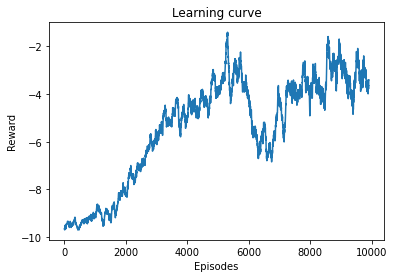

In [17]:
plt.plot(moving_average(episodes_reward, 100))
plt.title('Learning curve')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()

In [18]:
env = wrap_env(gym.make("Switch2-v0"))
obs_n = env.reset()
reward = 0

while True:
  obs_n, reward_n, done_n, info = env.step(agents.get_actions(obs_n))

  reward += sum(reward_n)

  env.render()

  if all(done_n):
    agents.memory.clear()
    break

env.close()
show_video()
print(reward)

ContextException: Could not create GL context